In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp
import random
import gillespie 
from scipy.interpolate import interp1d
import pdb

In [13]:
#mu=0.05
mu=0.07
#c=0.01
c=0.0025
delta=1
#K=100
K=60
T=1200
sto_realisations=1000


# Matrice de stoichiométrie
V = np.array([[-1, 0, 1, 0],
              [0, -1, 0, 1]])

In [14]:
h0=0.4

#on essaye d'éviter la division par 0 rho==0 and h0==1
if (delta==0 and h0==1): 
    w0=0
    m0=K
else:
    w0 = (1-h0)*K/(1-h0+delta*h0)
    m0 = h0*K/(1-h0+delta*h0)

# Initialisation de l'état initial
X = np.array([w0,m0])
print(X)

[36. 24.]


In [15]:
#epsilon parameters that can make the number of mutants increase
rho_min=0

rho=0.025
print(rho)

0.025


In [16]:
def rate_function(rates):
    return max(rates,0)  

In [17]:
from tqdm import tqdm
# Simulation des populations
all_times = []
all_populations = []

for sim in tqdm(range(sto_realisations), desc="Simulations"):
    t = 0
    times_sim = [t]
    X = np.array([w0,m0])
    pop_sim = [X.copy()]
   

    while t <= T:
        # Calcul des taux
        a = np.array([rate_function(mu * X[0]),
                      rate_function((mu-rho)* X[1]),
                      rate_function((mu + c * (K - X[0] - X[1]))*X[0]),
                      rate_function((mu-rho+c * (K - X[0] - X[1]))*X[1])])
        
        
        # Somme des taux
        somme = np.sum(a)
        # Debug print
        #print(f'Simulation {sim}, t = {t:.4f}, X = {X}, a = {a}, rate_sum = {somme:.4f}')
        if somme==0:
            print('No more events possible, breaking out of the loop.')
            break 
            
         # Sélection de la réaction
        r1 = np.random.rand()
        r_compare= r1*somme
        
        cumulative_sum = np.cumsum(a)
        j = np.searchsorted(cumulative_sum, r_compare)
        # Debugging information
        #print(f'Random number ξ1: {r1}')
        #print(f'Threshold for reaction selection: {r_compare}')
        #print(f'Cumulative sums: {cumulative_sum}, Selected reaction: {j}')
        
           # Vérification que j est bien sélectionné parmi les réactions disponibles
        if j >= len(a):
            print(f'Error: j ({j}) is out of bounds for array a with length {len(a)}.')
            break
            
            
        X += V[:, j ]
        
        
        # Calcul du temps d'événement
        r2 = np.random.rand()
        tau = np.log(1 / r2) / somme
        
        # Mettre à jour le temps
        t += tau
        if t > T:
            break
        times_sim.append(t)
        pop_sim.append(X.copy())
    
    # Enregistrer les résultats de la simulation
    all_times.append(times_sim)
    all_populations.append(pop_sim)
 

Simulations: 100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


In [18]:
total_time=1200
time_points = np.linspace(0, total_time, num=20)


# Calculer la fraction de mutants et l'ensemble moyen
h_ensemble = np.zeros((len(time_points), sto_realisations))
m_ensemble=np.zeros((len(time_points), sto_realisations))
w_ensemble=np.zeros((len(time_points), sto_realisations))



for i in range(sto_realisations):
    times = all_times[i]
    populations = all_populations[i]
    
    for idx, t in enumerate(time_points):
        if t <= times[-1]:
            j = np.searchsorted(times, t)
            W, M = populations[j] if j < len(populations) else populations[-1]
            h_ensemble[idx, i] = M / (W + M)
            m_ensemble[idx,i]=M
            w_ensemble[idx,i]=W
        else:
            h_ensemble[idx, i] = h_ensemble[idx - 1, i]
            m_ensemble[idx, i] = m_ensemble[idx - 1, i]
            w_ensemble[idx, i] = w_ensemble[idx - 1, i]

h_mean = np.mean(h_ensemble, axis=1)
m_mean = np.mean(m_ensemble, axis=1)
w_mean = np.mean(w_ensemble, axis=1)

In [19]:
m_std=np.std(m_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
m_sem = m_std/ np.sqrt(sto_realisations)
m_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps
w_std=np.std(w_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
w_sem = w_std/ np.sqrt(sto_realisations)
w_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([0.        , 0.33226032, 0.45345102, 0.52901258, 0.59034218,
       0.63319004, 0.68156085, 0.72464265, 0.74739052, 0.77289945,
       0.7940321 , 0.81017592, 0.82616766, 0.83867584, 0.85747165,
       0.86740293, 0.88157347, 0.8861046 , 0.89832275, 0.89832275])

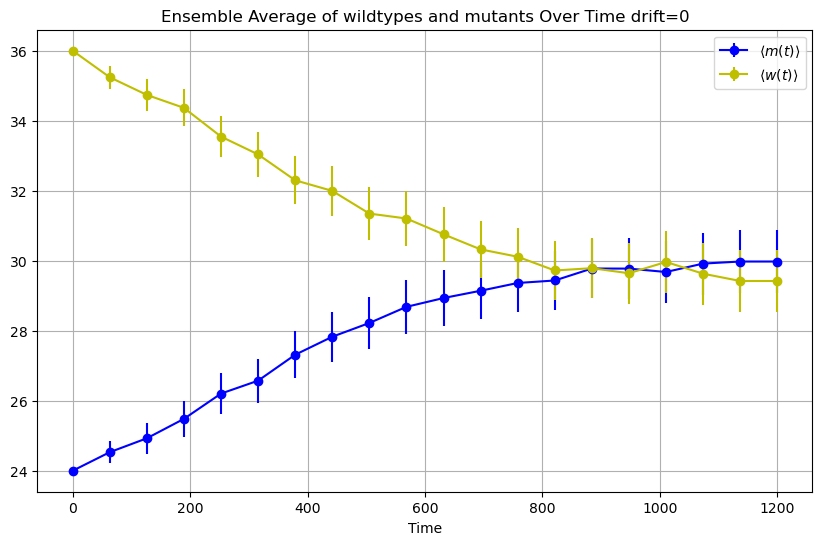

In [20]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, m_mean, yerr=m_sem, fmt='b-', marker='o', label=r'$\langle m(t) \rangle$')
plt.errorbar(time_points, w_mean, yerr=w_sem, fmt='y-', marker='o', label=r'$\langle w(t) \rangle$')
plt.xlabel('Time')
plt.title('Ensemble Average of wildtypes and mutants Over Time drift>0')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
h_std=np.std(h_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
h_sem = h_std/ np.sqrt(sto_realisations)
h_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([1.75541673e-18, 5.18602183e-03, 7.35446873e-03, 8.61663321e-03,
       9.69101057e-03, 1.04957987e-02, 1.12708565e-02, 1.19577561e-02,
       1.24334616e-02, 1.27815164e-02, 1.32060786e-02, 1.34874193e-02,
       1.37663683e-02, 1.40317546e-02, 1.42414544e-02, 1.44739720e-02,
       1.46148825e-02, 1.47574120e-02, 1.49106375e-02, 1.49106375e-02])

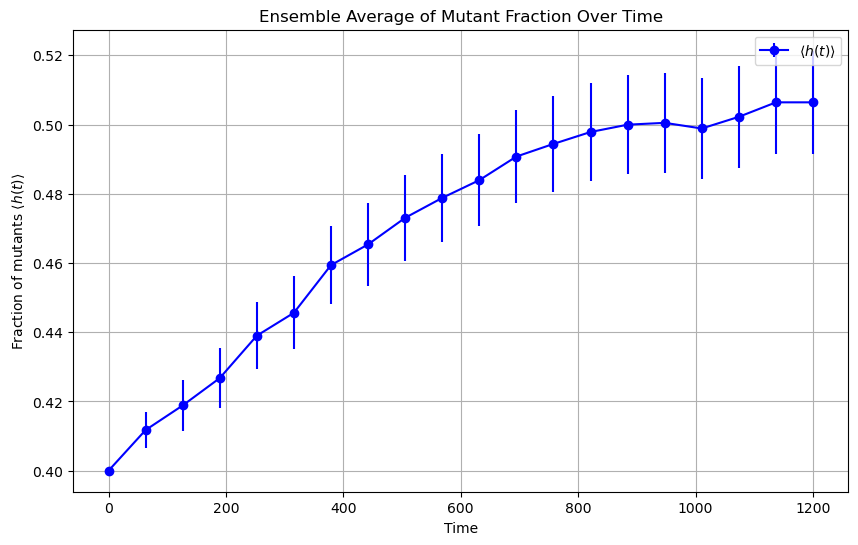

In [22]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, h_mean, yerr=h_sem, fmt='b-', marker='o', label=r'$\langle h(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Ensemble Average of Mutant Fraction Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
c=0.01
eps=0.01
K=50
def F(X,t):
    w,m=X[0],X[1]
    return (c*w*(K-w-m), c*m*(K-w-m))

temps=np.linspace(0,1200,1200)
sol=odeint(F,[87,58],temps)


In [24]:
w=sol[:,0]
m=sol[:,1]
h=m/(w+m)
#len(h)

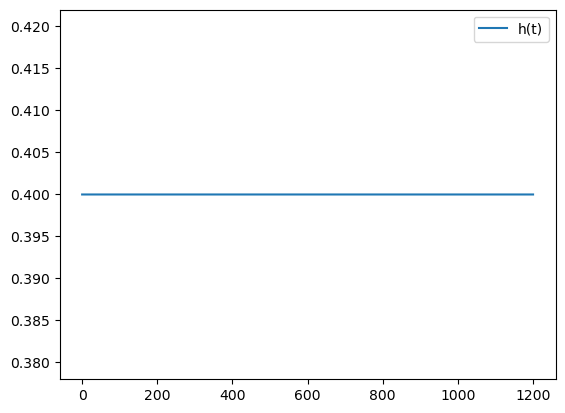

In [25]:
#plt.plot(temps, w, label='w(t)')
#plt.plot(temps, m, label='m(t)')

plt.plot(temps,h,label='h(t)')
# Ajout de légendes
plt.legend()

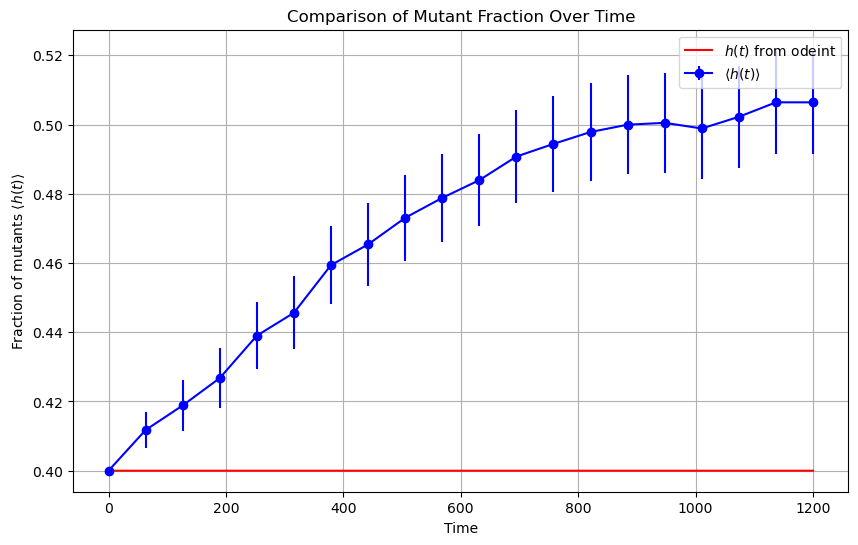

In [26]:

# Tracé des courbes
plt.figure(figsize=(10, 6))

# Tracer la courbe obtenue à partir des simulations
plt.errorbar(time_points, h_mean, yerr=h_sem, fmt='b-', marker='o', label=r'$\langle h(t) \rangle$')
# Tracer la courbe obtenue avec odeint
plt.plot(temps, h, 'r-', label=r'$h(t)$ from odeint')

# Ajout de légendes
plt.legend()

# Ajout de titres et d'étiquettes d'axes
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Comparison of Mutant Fraction Over Time')
plt.grid(True)

# Affichage du graphe
plt.show()
